In [1]:
import sys
sys.path.append("../../")
from torchgeo.datasets import CycloneDataModule
from torchgeo.trainers import RegressionTask
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
device = torch.device("cuda:1")

In [3]:
datamodule = CycloneDataModule(
    root_dir="/home/caleb/mount/data/cyclone/",
    seed=1337,
    batch_size=64,
    num_workers=6,
)
datamodule.setup()
datamodule.prepare_data()

In [4]:
model = RegressionTask(
    model="resnet18",
    pretrained=False,
)
model = model.load_from_checkpoint("../../output/cyclone_experiments/epoch=14-step=13634.ckpt")
model.freeze()
model = model.eval()
model = model.to(device)

In [5]:
y_pred = []
y_true = []
for batch in tqdm(datamodule.test_dataloader()):
    images = batch["image"].to(device)
    labels = batch["label"].numpy()
    with torch.no_grad():
        output = model(images).cpu().numpy()
    y_pred.append(output)
    y_true.append(labels)

100%|██████████| 694/694 [01:07<00:00, 10.22it/s]


In [6]:
images.shape, images.dtype, images.min(), images.max()

(torch.Size([25, 3, 366, 366]),
 torch.float32,
 tensor(0.0078, device='cuda:1'),
 tensor(0.9451, device='cuda:1'))

In [7]:
y_pred = np.concatenate(y_pred, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()

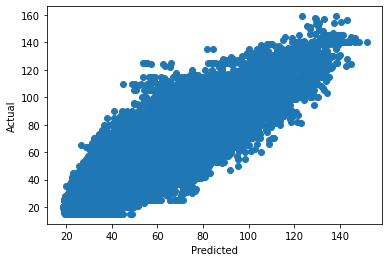

In [8]:
plt.figure()
plt.scatter(y_pred, y_true)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
plt.close()

In [9]:
np.sqrt(mean_squared_error(y_true, y_pred))

11.02597

In [10]:
r2_score(y_true, y_pred)

0.7919085969169163